In [1]:
from dask.distributed import LocalCluster, Client

# Cluster

In [ ]:
cluster = LocalCluster(n_workers=5, memory_limit=0.1, processes=False)
cluster

# No cluster

In [5]:
import os              
import urllib 

import dask.dataframe as dd

In [6]:
url = 'https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3A27e4043d-75eb-4c4f-9427-0d442526c154'

msg = urllib.request.urlretrieve(url, "dg_soil_moisture.csv")

In [7]:
fp = os.path.join(os.getcwd(),'dg_soil_moisture.csv')
df = dd.read_csv(fp, blocksize = '20MB' , encoding='ISO-8859-1')
df

,timestamp,year,doy,hour,minute,site,logger,port,sensor,sensorZ,m_soil,unit
npartitions=6,,,,,,,,,,,,
,object,int64,int64,int64,int64,object,object,object,object,int64,float64,object
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
df.head(2)

,timestamp,year,doy,hour,minute,site,logger,port,sensor,sensorZ,m_soil,unit
0,2014-07-07 16:30:00,2014,188,16,30,MDF1,MDF1met,Port 3,5TM Moisture/Temp,-6,0.273,m³/m³ VWC
1,2014-07-07 16:30:00,2014,188,16,30,MDF1,MDF1met,Port 4,5TM Moisture/Temp,-11,0.345,m³/m³ VWC


In [10]:
averages = df.groupby('year').mean()
averages

,doy,hour,minute,sensorZ,m_soil
npartitions=1,,,,,
,float64,float64,float64,float64,float64
,...,...,...,...,...


In [11]:
averages.compute()

,doy,hour,minute,sensorZ,m_soil
year,,,,,
2014,276.852636,11.513992,15.001123,-11.998332,0.273744
2015,186.720383,11.500723,15.000000,-13.047899,0.263738
2016,183.497453,11.499777,14.999858,-15.000009,0.293595
2017,181.414843,11.499381,15.000144,-14.999981,0.266121
2018,201.824077,11.500796,15.000356,-15.435365,0.282395
2019,173.693311,11.498577,15.000000,-15.124516,0.222193
2020,138.806679,11.489825,14.999322,-15.200054,0.252467


Out of curiosity I just did it without dask and it takes...less time? lol. idk.

In [15]:
import pandas as pd
df2 = pd.read_csv(fp,encoding='ISO-8859-1')
averages = df2.groupby('year').mean()
averages

,doy,hour,minute,sensorZ,m_soil
year,,,,,
2014,276.852636,11.513992,15.001123,-11.998332,0.273744
2015,186.720383,11.500723,15.000000,-13.047899,0.263738
2016,183.497453,11.499777,14.999858,-15.000009,0.293595
2017,181.414843,11.499381,15.000144,-14.999981,0.266121
2018,201.824077,11.500796,15.000356,-15.435365,0.282395
2019,173.693311,11.498577,15.000000,-15.124516,0.222193
2020,138.806679,11.489825,14.999322,-15.200054,0.252467


yeah so 114 MB isn't actually that big. It's all about the ratio of the size of your file/memory usage versus the computer you have at your disposal. For example, Joanmarie is terrible because she just sits on Dartmouth's shared memory computer and writes inefficient `.csv` files whereas maybe she doesn't have to sit there for three minutes while the csv reads and stuff. 

# Dask array

In [17]:
import numpy as np
import dask.array as da

In [18]:
data = np.arange(100_000).reshape(200, 500)
a = da.from_array(data, chunks=(100, 100))

In [24]:
a.mean().compute()

49999.5

In [25]:
# download red band
url = 'https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3Aac25a399-b174-41c1-b6d3-09974b161e5a'
msg = urllib.request.urlretrieve(url, "RU_ANS_TR2_FL005M_red.tif")


# download nir band
url = 'https://arcticdata.io/metacat/d1/mn/v2/object/urn%3Auuid%3A1762205e-c505-450d-90ed-d4f3e4c302a7'

msg = urllib.request.urlretrieve(url, "RU_ANS_TR2_FL005M_nir.tif")

In [37]:
import rioxarray as rxr

# read in the file
fp_red = os.path.join(os.getcwd(),"RU_ANS_TR2_FL005M_red.tif")
red = rxr.open_rasterio(fp_red, chunks = '15MB', masked=True)

In [38]:
red

<xarray.DataArray (band: 1, y: 3499, x: 7443)>
dask.array<open_rasterio-93fcc2c16088548dcc8c0a1a79a2a364<this-array>, shape=(1, 3499, 7443), dtype=float32, chunksize=(1, 1936, 1936), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.22e+05 6.22e+05 6.22e+05 ... 6.224e+05 6.224e+05
  * y            (y) float64 7.525e+06 7.525e+06 ... 7.525e+06 7.525e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [39]:
# getting rid of unnecessary dimension
red = red.squeeze()

In [40]:
# open data
fp_nir = os.path.join(os.getcwd(),"RU_ANS_TR2_FL005M_nir.tif")
nir = rxr.open_rasterio(fp_nir, chunks = '15MB', masked=True)

#squeeze
nir = nir.squeeze()

In [41]:
ndvi = (nir - red) / (nir + red)

In [42]:
ndvi_values = ndvi.compute()

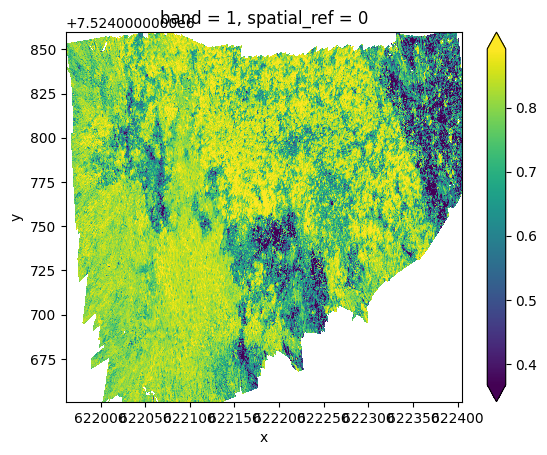

In [43]:
ndvi_values.plot(robust=True)